In [1]:
import matplotlib.pyplot as plt
import re
import pandas as pd
import h5py
import numpy as np
import seaborn as sns
from scipy.interpolate import interp1d
from common import CosmoInterpolator
import json

label_fontsize = 18
tick_fontsize = 18
title_fontsize = 18

plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Computer Modern"]
plt.rcParams["mathtext.fontset"] = "dejavuserif"
plt.rcParams["figure.figsize"] = (4, 3)


startup


In [2]:
cosmo = CosmoInterpolator()
h5_path = "snr_results.h5"
h5f = h5py.File(h5_path, "r")

In [3]:
processed_results = []
for source in h5f:
    # if "a=-0.99" in source:
    # Extract m1 and redshift using regex
    m1_match = re.search(r"m1=([0-9.eE+-]+)", source)
    z_match = re.search(r"z=([0-9.eE+-]+)", source)
    a_match = re.search(r"a=([0-9.eE+-]+)", source)
    if m1_match and z_match:
        m1 = float(m1_match.group(1))
        z = float(z_match.group(1))
        a = float(a_match.group(1))
        snr = h5f[source]["snr"][()]
        processed_results.append({'m1': m1, 'a': a, 'redshift': z, 'snr': snr})

# Convert to DataFrame for easier analysis
df_results = pd.DataFrame(processed_results)
# df_results.head()


In [4]:
m1_list = np.unique(df_results["m1"].to_numpy())

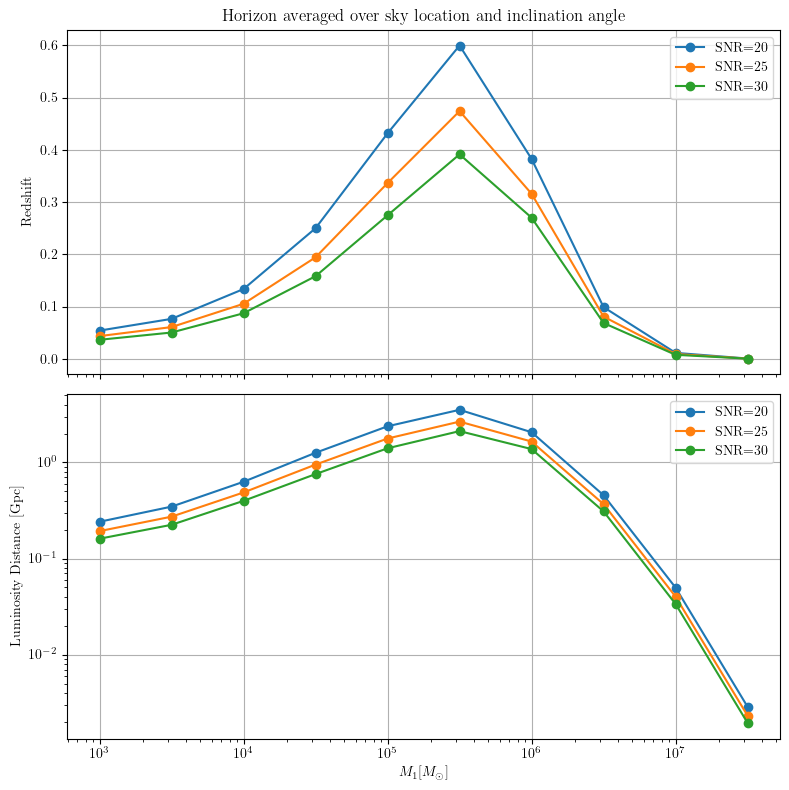

In [5]:
def get_redshift_from_snr(snr=20., m1=1e3, a=0.):
    df_temp = df_results[(df_results['m1'] == m1) & (df_results['a'] == a)]
    snr_z = np.vstack(df_temp["snr"].to_numpy())
    avg_snr = np.mean(snr_z, axis=1)
    interp_func = interp1d(np.log10(avg_snr), np.log10(df_temp["redshift"]), kind='linear', fill_value="extrapolate")
    z = 10 ** interp_func(np.log10(snr))
    lum_d = cosmo.get_luminosity_distance(z)
    return z, lum_d

snr_values = [20, 25, 30]
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 8))

for snr_val in snr_values:
    redshift_dl = np.asarray([get_redshift_from_snr(snr=snr_val, m1=m1) for m1 in m1_list])
    redshift = redshift_dl[:, 0]
    luminosity_distance = redshift_dl[:, 1]
    ax1.semilogx(m1_list, redshift, label=f"SNR={snr_val}", marker='o')
    ax2.loglog(m1_list, luminosity_distance, label=f"SNR={snr_val}", marker='o')

ax1.set_ylabel("Redshift")
ax1.set_title("Horizon averaged over sky location and inclination angle")
ax1.grid()
ax1.legend()

ax2.set_xlabel(r"$M_1 [M_\odot]$")
ax2.set_ylabel("Luminosity Distance [Gpc]")
ax2.grid()
ax2.legend()

plt.tight_layout()
plt.show()

In [6]:
# fixed
snr_evaluation = 25.
snr_thresholds = [20., 20.*np.sqrt(2), 20.*np.sqrt(4)]
snr_labels = [(snr_thresholds[0], "green"), (snr_thresholds[1], "yellow"), (snr_thresholds[2], "red")]

snr_ranges = [float(np.round(snr_thresholds[ii],decimals=1)) for ii in range(len(snr_thresholds))]
labels = [str(snr_ranges[0])+"$<$SNR$<$"+str(snr_ranges[1]), str(snr_ranges[1])+"$<$SNR$<$"+str(snr_ranges[2]), str(snr_ranges[2])+"$<$SNR"]
snr_labels = [(snr_thresholds[0], "green", labels[0]), (snr_thresholds[1], "yellow", labels[1]), (snr_thresholds[2], "red", labels[2])]

# how to create a redshift based requirement
with h5py.File("snr_requirements_summary.h5", "w") as hf:
    for snr, color, labs in snr_labels:
        grp = hf.create_group(color)
        requirement_ = {float(a): np.hstack((m1_list[:, np.newaxis], np.asarray([get_redshift_from_snr(snr=snr, m1=m1, a=a) for m1 in m1_list]))) for a in np.unique(df_results["a"].to_numpy())}
        for a_val, arr in requirement_.items():
            dset = grp.create_dataset(f"a_{a_val}", data=arr)
            dset.attrs["columns"] = np.array(["m1 (source frame primary mass in solar masses)", "redshift (averaged over sky location and inclination angle)", "luminosity distance (averaged over sky location and inclination angle in Gpc)"], dtype="S")
        grp.attrs["description"] = f"Results for SNR={snr}, color={color}"
    hf.attrs["info"] = "Each group contains datasets for the redshift requirement at a given SNR threshold."
 # The science objective is red if below the yellow threshold, yellow if between the yellow and the green threshold, and green if between the green and blue threshold.

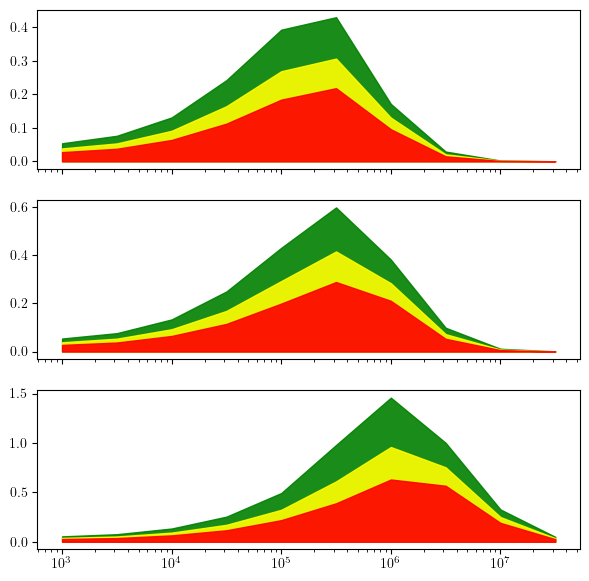

In [7]:

with h5py.File("snr_requirements_summary.h5", "r") as hf:
    spins = [-0.99, 0.0, 0.99]
    fig, axes = plt.subplots(3, 1, figsize=(7, 7), sharex=True)
    for idx, spin in enumerate(spins):
        ax = axes[idx]
        list_z = []
        # requirements
        for snr, color, ll in snr_labels:
            grp = hf[color]
            arr = grp[f"a_{spin}"][:]
            m1_vals = arr[:, 0]
            z_vals = arr[:, 1]
            # ax.semilogx(m1_vals, z_vals, label=ll, color=color)
            list_z.append(z_vals)
        
            ax.fill_between(m1_vals, z_vals, alpha=0.9, color=color, label=ll)
        example_ = np.asarray(list_z)
        ax.set_xscale("log")


In [8]:
print("example for spin",spin)
print("blue\nfrom",example_[0],"\nto inf")
print("\n")
print("green\nfrom",example_[1],"\nto",example_[0])
print("\n")
print("yellow\nfrom",example_[2],"\nto",example_[1])
print("\n")
print("red\nfrom",example_[2]*0.0,"\nto",example_[2])

example for spin 0.99
blue
from [0.05471991 0.07664055 0.1342886  0.25431964 0.49361812 0.97979259
 1.45908474 1.00176355 0.32726739 0.05003177] 
to inf


green
from [0.03921525 0.0536299  0.09288667 0.17178057 0.32363986 0.61091313
 0.95918162 0.75376779 0.2502301  0.03678464] 
to [0.05471991 0.07664055 0.1342886  0.25431964 0.49361812 0.97979259
 1.45908474 1.00176355 0.32726739 0.05003177]


yellow
from [0.02795368 0.03752799 0.06472189 0.11657716 0.21894953 0.38947881
 0.6305524  0.56716565 0.19132704 0.02645694] 
to [0.03921525 0.0536299  0.09288667 0.17178057 0.32363986 0.61091313
 0.95918162 0.75376779 0.2502301  0.03678464]


red
from [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 
to [0.02795368 0.03752799 0.06472189 0.11657716 0.21894953 0.38947881
 0.6305524  0.56716565 0.19132704 0.02645694]


In [9]:
def get_redshift_range(redshift, example_):
    """
    Given a redshift value (or array) and the example_ array, returns the SNR range label:
    - "blue" if redshift > example_[0]
    - "green" if example_[1] < redshift <= example_[0]
    - "yellow" if example_[2] < redshift <= example_[1]
    - "red" if redshift <= example_[2]
    example_ shape: (3, N)
    redshift: float or array-like of length N
    """
    check_blue = (example_[0]<redshift) and (redshift<example_[0]+100.)
    check_green = (example_[1]<redshift) and (redshift<example_[0])
    check_yellow = (example_[2]<redshift) and (redshift<example_[1])
    check_red = redshift<example_[2]
    # print("check_blue", check_blue)
    # print("check_green", check_green)
    # print("check_yellow", check_yellow)
    # print("check_red", check_red)

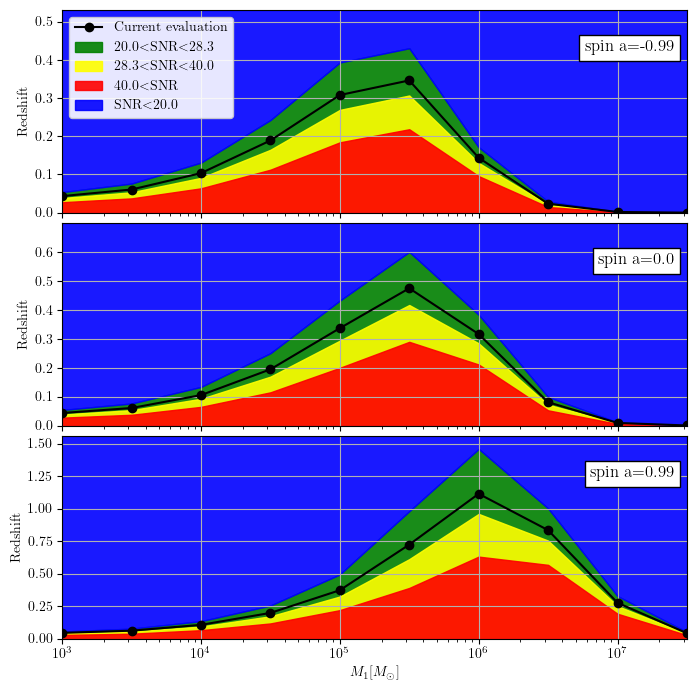

In [10]:
json_data = {}
with h5py.File("snr_requirements_summary.h5", "r") as hf:
    spin = 0.0
    spins = [-0.99, 0.0, 0.99]
    fig, axes = plt.subplots(3, 1, figsize=(7, 7), sharex=True)
    for idx, spin in enumerate(spins):
        ax = axes[idx]
        # current evaluation
        redshift_dl = np.asarray([get_redshift_from_snr(snr=snr_evaluation, m1=m1, a=spin) for m1 in m1_list])
        redshift = redshift_dl[:, 0]
        ax.semilogx(m1_list, redshift, color='k', marker='o', label='Current evaluation')
        
        list_z = []
        # requirements
        for snr, color, ll in snr_labels:
            grp = hf[color]
            arr = grp[f"a_{spin}"][:]
            m1_vals = arr[:, 0]
            z_vals = arr[:, 1]
            # ax.semilogx(m1_vals, z_vals, label=ll, color=color)
            ax.fill_between(m1_vals, z_vals, alpha=0.9, color=color, label=ll)
            # check if redshift in z_vals
            # print(color, "is horizon redshift above? ",np.sum(redshift<z_vals)==0)
            list_z.append(z_vals)
        
        example_ = np.asarray(list_z)
        # print(get_redshift_range(redshift, example_))
        
        # blue
        ax.set_xscale("log")
        arr_red = hf["green"][f"a_{spin}"][:]
        m1_vals_red = arr_red[:, 0]
        z_vals_red = np.zeros_like(arr_red[:, 1]) + arr_red[:, 1].max() + 0.1
        ax.fill_between(m1_vals_red, arr_red[:, 1], z_vals_red, alpha=0.9, color="blue", label= "SNR$<$"+str(snr_ranges[0]))


        ax.text(0.98, 0.85, f"spin a={spin}", transform=ax.transAxes, fontsize=12, ha='right', va='top',
                bbox=dict(facecolor='white', alpha=1.0, ))# edgecolor='none'
        ax.grid()
        if idx == 0:
            ax.legend(loc='upper left', fontsize=10, framealpha=0.9)
        ax.set_ylim(0, arr_red[:, 1].max() + 0.1)
        ax.set_xlim(m1_list.min(), m1_list.max())
        # Store results for each spin in the json_data dictionary
        json_data[str(spin)] = {
            "m1": m1_list.tolist(),
            "redshift": redshift.tolist()
        }
    # axes[0].set_title(f"Requirement for redshift horizon with SNR={snr_evaluation}")
    axes[-1].set_xlabel(r"$M_1 [M_\odot]$")
    for ax in axes:
        ax.set_ylabel("Redshift")
    plt.tight_layout(h_pad=0.2)
    plt.savefig(f"requirements_results/snr_redshift_requirement_allspins.png", dpi=300)
with open(f"requirements_results/snr_redshift_evaluation.json", "w") as f:
    json.dump(json_data, f, indent=4)

# Fake a sensitivity reduction
We want to understand how much freedom we are giving to the overall sensitivity. We assume a factor of 2 larger noise floor power spectral density $S_n(f)\rightarrow 2 S_n(f)$ leads to an SNR reduction of SNR$\rightarrow$SNR$/\sqrt{2}$

In [11]:
factor_sens = 2.0

def get_redshift_from_snr(snr=20., m1=1e3, a=0.):
    df_temp = df_results[(df_results['m1'] == m1) & (df_results['a'] == a)]
    snr_z = np.vstack(df_temp["snr"].to_numpy())/np.sqrt(factor_sens)
    avg_snr = np.mean(snr_z, axis=1)
    interp_func = interp1d(np.log10(avg_snr), np.log10(df_temp["redshift"]), kind='linear', fill_value="extrapolate")
    z = 10 ** interp_func(np.log10(snr))
    lum_d = cosmo.get_luminosity_distance(z)
    return z, lum_d


/tmp/ipykernel_3040582/4146428898.py:32: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, arr_red[:, 1].max() + 0.1)


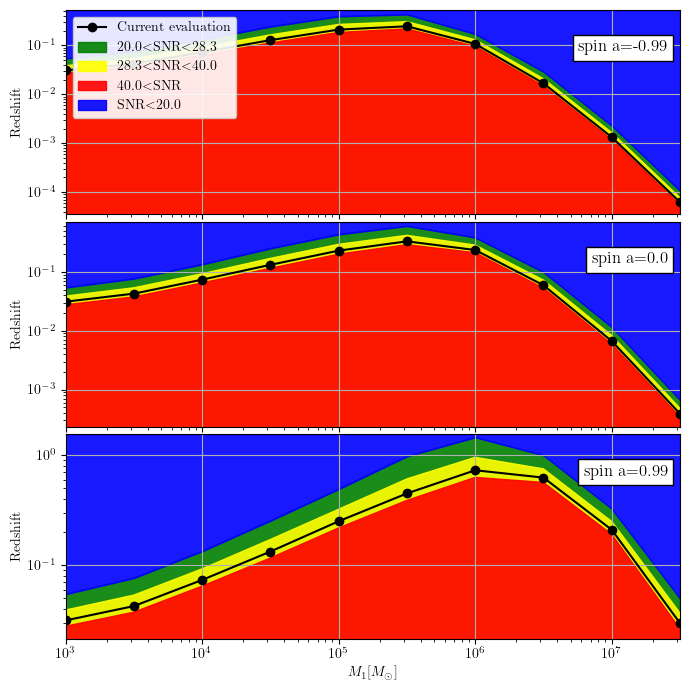

In [12]:


json_data = {}
with h5py.File("snr_requirements_summary.h5", "r") as hf:
    spin = 0.0
    spins = [-0.99, 0.0, 0.99]
    fig, axes = plt.subplots(3, 1, figsize=(7, 7), sharex=True)
    for idx, spin in enumerate(spins):
        ax = axes[idx]
        # current evaluation
        redshift_dl = np.asarray([get_redshift_from_snr(snr=snr_evaluation, m1=m1, a=spin) for m1 in m1_list])
        redshift = redshift_dl[:, 0]
        ax.semilogx(m1_list, redshift, color='k', marker='o', label='Current evaluation')
        
        # requirements
        for snr, color, ll in snr_labels:
            grp = hf[color]
            arr = grp[f"a_{spin}"][:]
            m1_vals = arr[:, 0]
            z_vals = arr[:, 1]
            # ax.semilogx(m1_vals, z_vals, label=ll, color=color)
            ax.fill_between(m1_vals, z_vals, alpha=0.9, color=color, label=ll)
        
        arr_red = hf["green"][f"a_{spin}"][:]
        m1_vals_red = arr_red[:, 0]
        z_vals_red = np.zeros_like(arr_red[:, 1]) + arr_red[:, 1].max() + 0.1
        ax.fill_between(m1_vals_red, arr_red[:, 1], z_vals_red, alpha=0.9, color="blue", label= "SNR$<$"+str(snr_ranges[0]))
        ax.set_yscale("log")
        ax.text(0.98, 0.85, f"spin a={spin}", transform=ax.transAxes, fontsize=12, ha='right', va='top',
                bbox=dict(facecolor='white', alpha=1.0, ))# edgecolor='none'
        ax.grid()
        if idx == 0:
            ax.legend(loc='upper left', fontsize=10, framealpha=0.9)
        ax.set_ylim(0, arr_red[:, 1].max() + 0.1)
        ax.set_xlim(m1_list.min(), m1_list.max())
        # Store results for each spin in the json_data dictionary
        json_data[str(spin)] = {
            "m1": m1_list.tolist(),
            "redshift": redshift.tolist()
        }
    # axes[0].set_title(f"Requirement for redshift horizon with SNR={snr_evaluation}")
    axes[-1].set_xlabel(r"$M_1 [M_\odot]$")
    for ax in axes:
        ax.set_ylabel("Redshift")
    plt.tight_layout(h_pad=0.2)